In [3]:
%matplotlib inline
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import wradlib as wrl
import pyart
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()

In [4]:
radar = nc.Dataset('MDV-20150805-084449-PPIVol.nc')

In [5]:
dbz=radar.variables['DBZH'][:].data
dbz[dbz==-32768]=np.nan
dbz.shape

(9270, 2500)

In [6]:
mask_dbz=radar.variables['DBZH'][:].mask
velh=pd.DataFrame(radar.variables['VELH'][:].data)
velh=velh.replace(-32768,np.nan)
#vleh=vleh.values*mask_dbzh

In [7]:
~mask_dbz

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

In [8]:
np_velh=pd.DataFrame(velh)
pd_dbz=pd.DataFrame(~mask_dbz)
velh=np_velh[pd_dbz]

In [9]:
velh.shape

(9270, 2500)

In [10]:
rad = pyart.io.read('MDV-20150805-084449-PPIVol.nc')
mask_dict = {'data': velh, 'units': 'm/s', 'long_name': 'corr_vel',
            'standard_name': 'Corrected VEL'}
rad.add_field('velh',mask_dict)

In [11]:
rad.fields.keys()

dict_keys(['DBZH', 'DBZV', 'VELH', 'VELV', 'velh'])

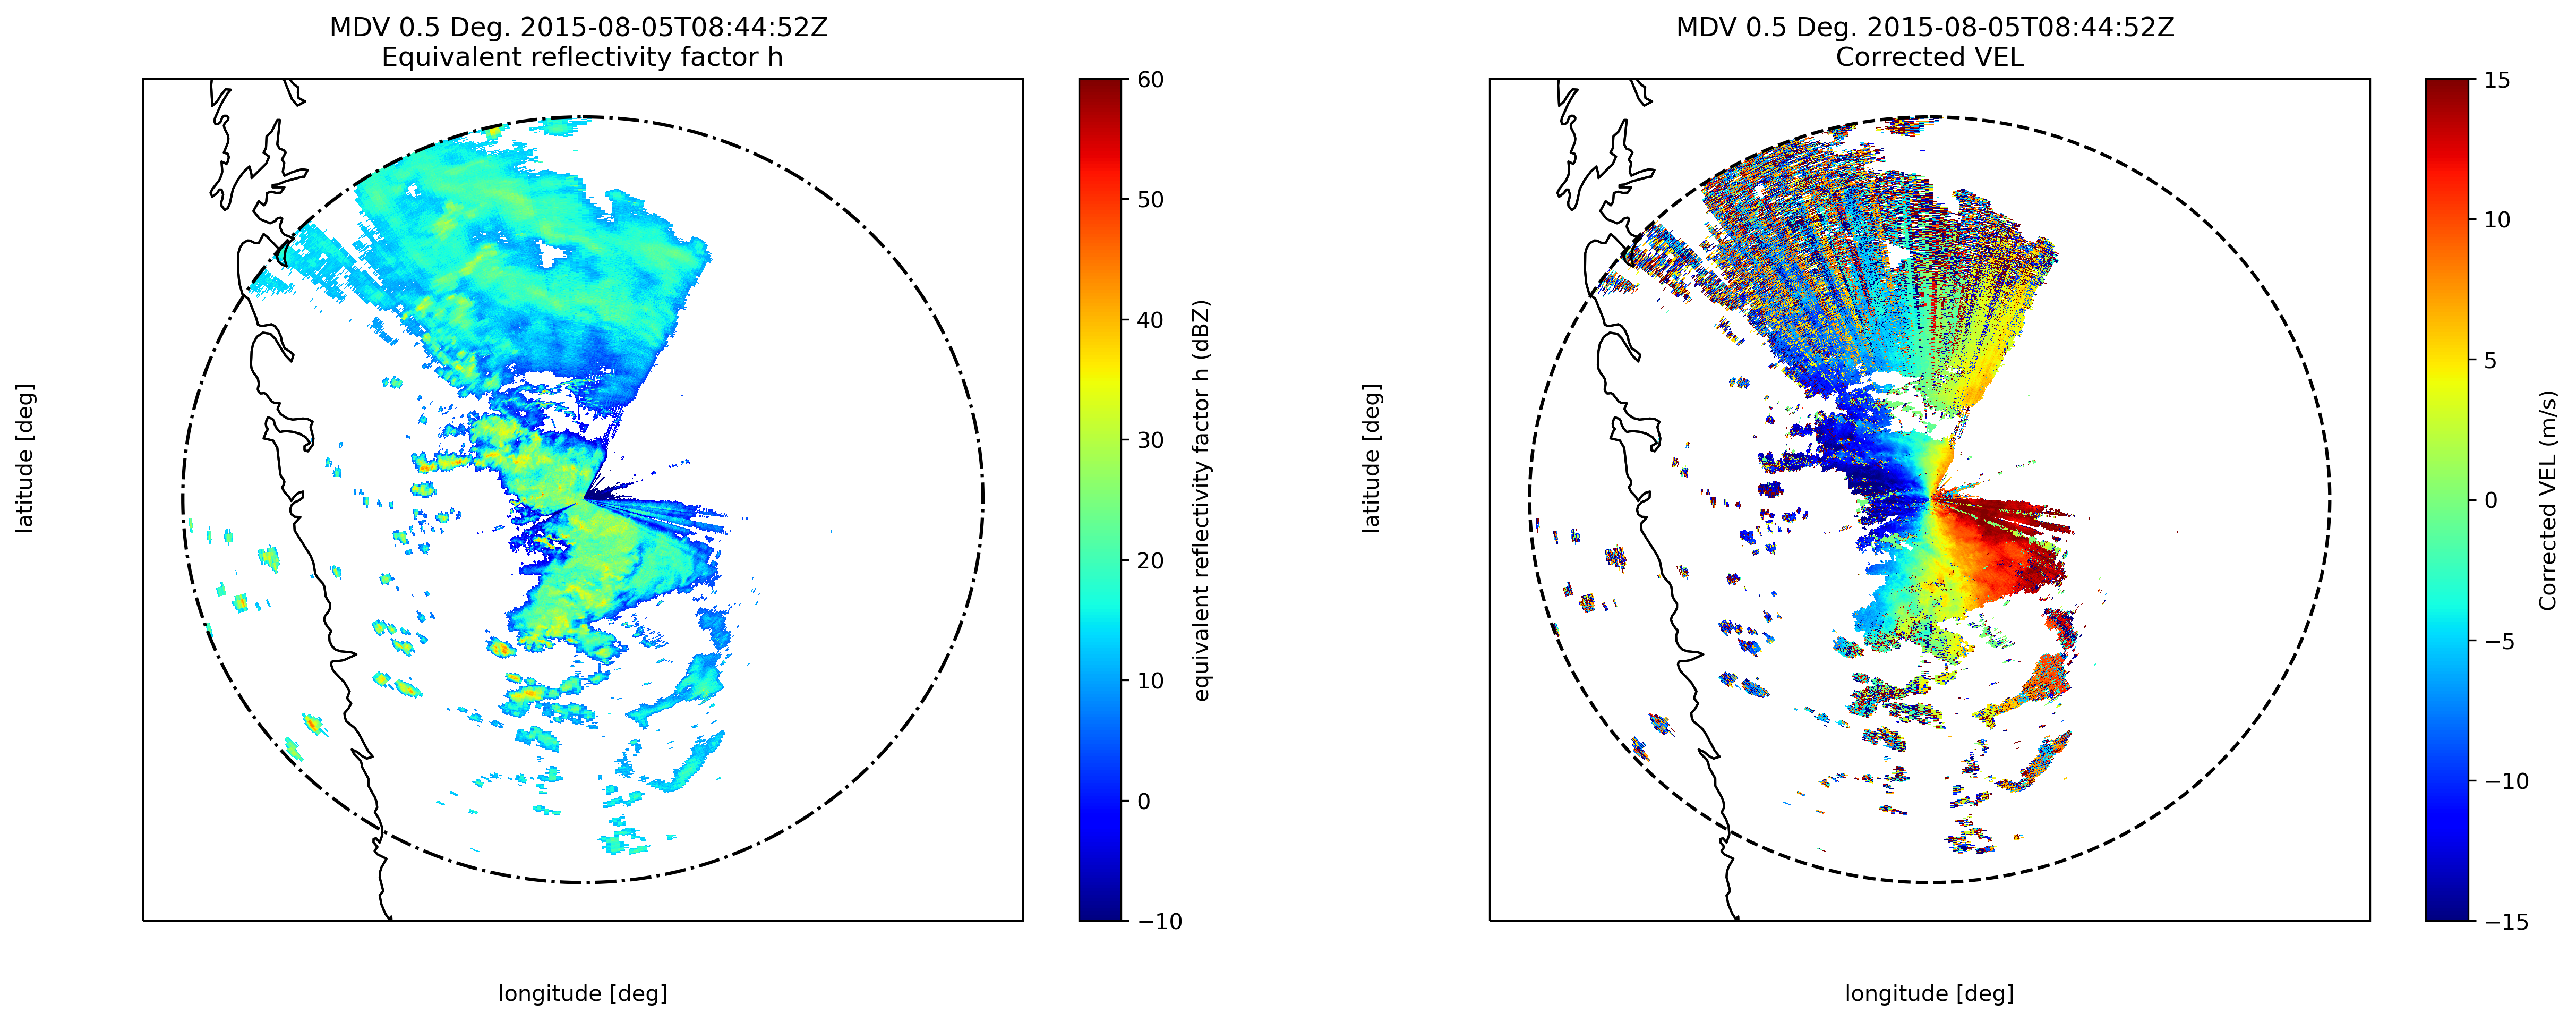

In [12]:
for i in range(1):
    fig = plt.figure(figsize=[20,7],dpi=300)
    ax = plt.subplot(1,2,1,projection=ccrs.PlateCarree())
    display = pyart.graph.RadarMapDisplay(rad)
    display.plot_ppi_map('DBZH',sweep=i, resolution='10m',
                         vmin=-10, vmax=60,
                         projection=ccrs.PlateCarree(), cmap='jet',)
    display.plot_range_ring(rad.range['data'][2], line_style='k-.')

    ax = plt.subplot(1,2,2,projection=ccrs.PlateCarree())
    display = pyart.graph.RadarMapDisplay(rad)
    display.plot_ppi_map('velh', sweep=i, resolution='10m',
                         vmin = -15, vmax = 15,
                         projection=ccrs.PlateCarree(),cmap='jet')
    display.plot_range_ring(rad.range['data'][2], line_style='k--')
    #fig.tight_layout()
    #plt.savefig('/Users/rizvi/Documents/Project/Jup/plots'+'//'+'MDV-20150805-084449-PPIVol'+ str(i+1) +'.jpg')
    #plt.clf()
    plt.show()

# Rainfall Rate

In [13]:
z=dbz
b=1.6
a=200
R=(z/a)**(1/b)
np.shape(R)

(9270, 2500)

In [14]:
mask_dict = {'data': R, 'units': 'mm/hr', 'long_name': 'rain rate', 'standard_name': 'R'}
rad.add_field('R',mask_dict)

In [15]:
rad.fields.keys()

dict_keys(['DBZH', 'DBZV', 'VELH', 'VELV', 'velh', 'R'])

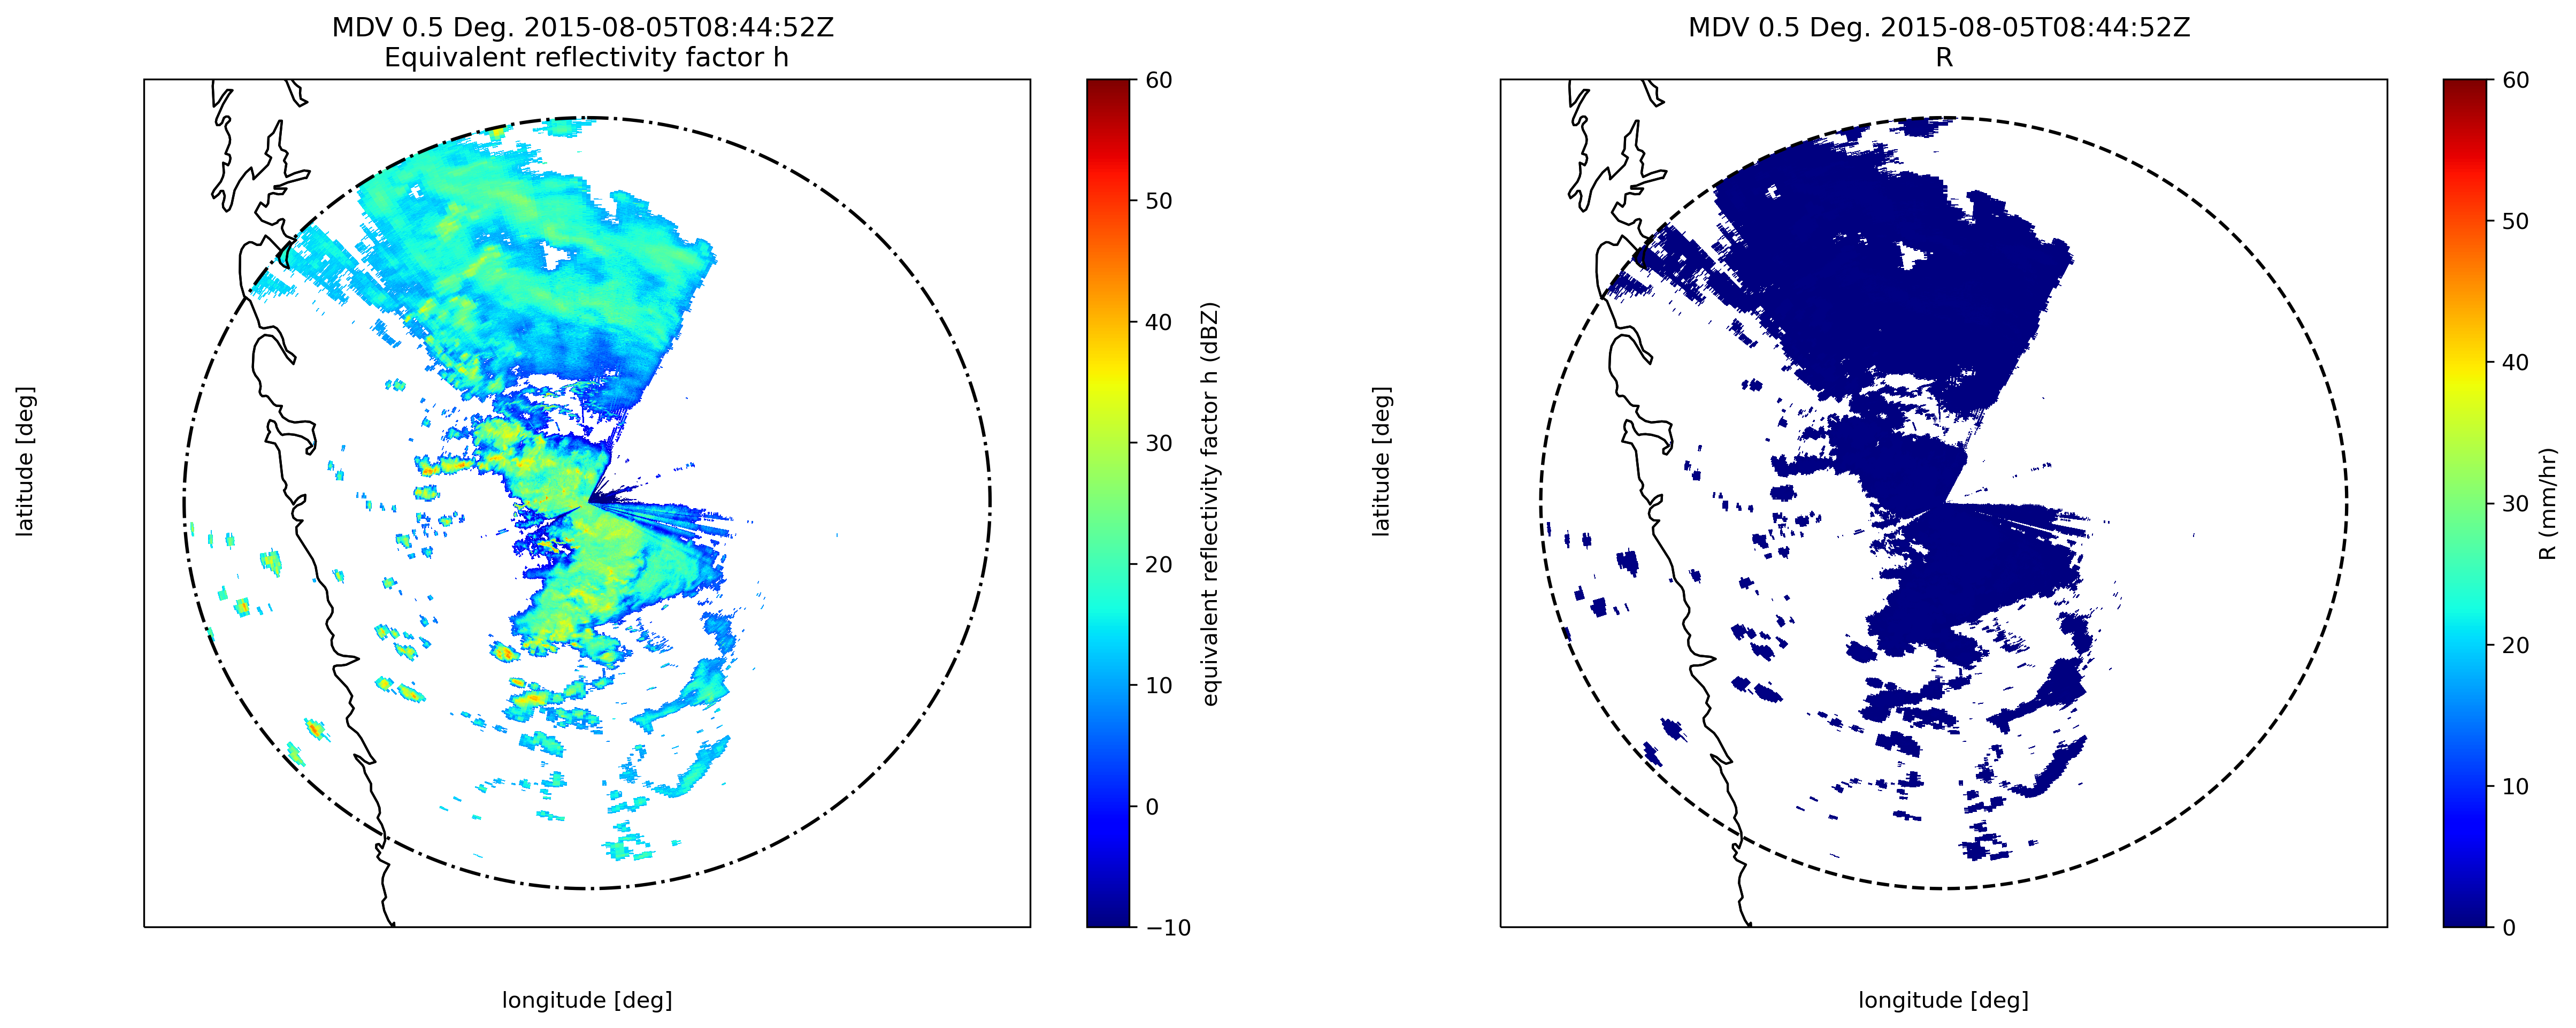

In [16]:
for i in range(1):
    fig = plt.figure(figsize=[20,7],dpi=300)
    ax = plt.subplot(1,2,1,projection=ccrs.PlateCarree())
    display = pyart.graph.RadarMapDisplay(rad)
    display.plot_ppi_map('DBZH',sweep=i, resolution='10m',
                         vmin=-10, vmax=60,
                         projection=ccrs.PlateCarree(), cmap='jet',)
    display.plot_range_ring(rad.range['data'][2], line_style='k-.')

    ax = plt.subplot(1,2,2,projection=ccrs.PlateCarree())
    display = pyart.graph.RadarMapDisplay(rad)
    display.plot_ppi_map('R', sweep=i, resolution='10m',
                         vmin=-0, vmax=60,
                         projection=ccrs.PlateCarree(),cmap='jet')
    display.plot_range_ring(rad.range['data'][2], line_style='k--')
    #plt.ylabel(max(R))
    #fig.tight_layout()
    #plt.savefig('/Users/rizvi/Documents/Project/Jup/plots'+'//'+'R_MDV-20150805-084449-PPIVol'+ str(i+1) +'.jpg')
    #plt.clf()
    plt.show()

In [17]:
rad.info('compact')

altitude: <ndarray of type: float64 and shape: (1,)>
altitude_agl: None
antenna_transition: None
azimuth: <ndarray of type: float32 and shape: (9270,)>
elevation: <ndarray of type: float32 and shape: (9270,)>
fields:
	DBZH: <ndarray of type: float32 and shape: (9270, 2500)>
	DBZV: <ndarray of type: float32 and shape: (9270, 2500)>
	VELH: <ndarray of type: float32 and shape: (9270, 2500)>
	VELV: <ndarray of type: float32 and shape: (9270, 2500)>
	velh: <not a ndarray>
	R: <ndarray of type: float32 and shape: (9270, 2500)>
fixed_angle: <ndarray of type: float32 and shape: (18,)>
instrument_parameters:
	frequency: <ndarray of type: float32 and shape: (1,)>
	pulse_width: <ndarray of type: float32 and shape: (9270,)>
	prt_mode: <ndarray of type: |S1 and shape: (18, 10)>
	prt: <ndarray of type: float32 and shape: (9270,)>
	prt_ratio: <ndarray of type: float32 and shape: (9270,)>
	polarization_mode: <ndarray of type: |S1 and shape: (18, 10)>
	nyquist_velocity: <ndarray of type: float32 and sh

In [18]:
lat = rad.latitude['data']
lon = rad.longitude['data']
ele = rad.elevation['data']
azm = rad.azimuth['data']
r = rad.range['data']

In [19]:
def check_dimensions(rad, field='DBZH'):
    """
    Check if field dimensions are constants across elevations
    """
    dim0 = rad.fields[field]['data'][rad.get_slice(0)].shape
    for ns in range(1, rad.nsweeps):
        if dim0 != rad.fields[field]['data'][rad.get_slice(ns)].shape:
            raise ValueError("dimension mismatch.")
    return True

In [20]:
cappi_altitude = 1000  # Altitude in m for the CAPPI

In [21]:
# Reshape field into a 3D array (elevation, azimuth, range)
if check_dimensions(rad):
    refl = rad.fields['DBZH']['data'].copy()
    dim0 = refl[rad.get_slice(0)].shape

    ref3dorig = refl.reshape((rad.nsweeps, dim0[0], dim0[1]))
    ref3d = np.zeros_like(ref3dorig)
    
    # Sorting azimuth, put azimuth 0 at index 0, second azimuth at index 1, ...
    for ns in range(rad.nsweeps):
        azi = rad.azimuth['data'][rad.get_slice(ns)]
        pos = np.argsort(azi)    
        for i, p in enumerate(pos):
            ref3d[ns, i, :] = ref3dorig[ns, p, :].copy()

In [22]:
ref3d.shape

(18, 515, 2500)

In [23]:
elevation = np.unique(rad.elevation['data'])
r = rad.range['data']
azi = np.linspace(0, 359, dim0[0])

# Convert azimuth to polar
theta = (450 - azi)
theta[theta >= 360] -= 360

THETA, PHI, R = np.meshgrid(theta, elevation, r)

# Radar spherical to cartesian
X = R * np.cos(PHI * np.pi / 180) * np.cos(THETA * np.pi / 180)
Y = R * np.cos(PHI * np.pi / 180) * np.sin(THETA * np.pi / 180)
Z = R * np.sin(PHI * np.pi / 180)

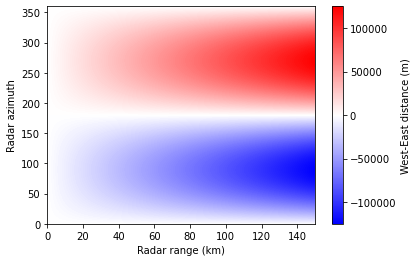

In [24]:
plt.imshow(X[0, :, :], extent=[0, 150, 0, 360], origin='upper', aspect='auto', cmap='bwr')
plt.colorbar(label='West-East distance (m)')
plt.xlabel('Radar range (km)')
plt.ylabel('Radar azimuth')
plt.show()

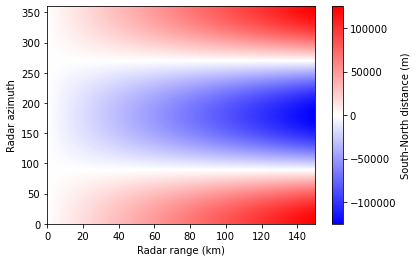

In [25]:
plt.imshow(Y[0, :, :], extent=[0, 150, 0, 360], origin='upper', aspect='auto', cmap='bwr')
plt.colorbar(label='South-North distance (m)')
plt.xlabel('Radar range (km)')
plt.ylabel('Radar azimuth')
plt.show()

In [39]:
posslice = np.argmin(np.abs(Z - cappi_altitude), axis=0)

CAPPI = np.zeros((dim0[0], dim0[1]))
XC = np.zeros((dim0[0], dim0[1]))
YC = np.zeros((dim0[0], dim0[1]))
for i in range(dim0[1]):
    for j in range(dim0[0]):
        CAPPI[j, i] = ref3d[posslice[j, i], j, i]
        XC[j, i] = X[posslice[j, i], j, i]
        YC[j, i] = Y[posslice[j, i], j, i]

IndexError: index 51 is out of bounds for axis 0 with size 18

In [27]:
# setup projection for south india
# http://spatialreference.org/ref/epsg/kalianpur-1975-india-zone-iv/
from osgeo import osr
proj = osr.SpatialReference()
proj.ImportFromEPSG(24383)

0

In [28]:
sitecoords = (float(lat), float(lon), 0.)
sitecoords

(18.04290008544922, 73.86896514892578, 0.0)

In [ ]:
# calculate slice coordinates
xyz_ = wrl.vpr.volcoords_from_polar(sitecoords, ele, azi, r,proj)

In [ ]:
wrl.vpr.CAPPI(polcoords, gridcoords, gridshape=None, maxrange=None, minelev=None, maxelev=None, ipclass=<class 'wradlib.ipol.Idw'>, **ipargs)